### 統計學習與深度學習
### Homework 2
B07902034 資工三 王昱凱
### 第一題 [Data Preprocessing]
此題我們需要對從UCI上下載的dataset做preprocessing，而對於實作preprocessing，我大致上分為三個步驟：
* 先從檔案裡逐行將資料讀出並且以逗號分隔開存入nparray裡，接著將有缺值的資料移除，而y為資料中的最後一個feature，將>50K和<=50K轉換為1和0的label
* 為了做1-of-K encoding，需要先對連續性資料中的每個field的每種feature做統計，接著將出現次數不到10次的feature移除，移除後我個別對每個field中的features按照字母做排序
* 將統計好的feature按照助教所提供的順序將每個field做合併，最後再將每筆資料按照建立好的1-of-K encoding格式讀入，並且讀完後以訓練資料的平均和標準差做標準化即可完成

In [15]:
import pickle
import numpy as np

# load the data by lines and split them with ", "
with open('adult.data') as f:
    X_train = np.array([line.strip('\n').split(', ')[:-1] for line in f])
with open('adult.data') as f:
    Y_train = np.array([line.strip('\n').split(', ')[-1] for line in f])
with open('adult.test') as f:
    next(f)
    X_test = np.array([line.strip('\n').split(', ')[:-1] for line in f])
with open('adult.test') as f:
    next(f)
    Y_test = np.array([line.strip('\n').split(', ')[-1] for line in f])
    
# the last line in the file is an empty string
X_train = X_train[:-1]
Y_train = Y_train[:-1]
X_test = X_test[:-1]
Y_test = Y_test[:-1]

# remove the row with missing value
i = 0
while i < len(X_train):
    if '?' in X_train[i]:
        X_train = np.delete(X_train, i, 0)
        Y_train = np.delete(Y_train, i)
        i = i-1
    i = i+1
    
i = 0
while i < len(X_test):
    if '?' in X_test[i]:
        X_test = np.delete(X_test, i, 0)
        Y_test = np.delete(Y_test, i)
        i = i-1
    i = i+1

# set y_train and y_test to binary-valued
y_train = np.array([1 if y == '>50K' else 0 for y in Y_train])
y_test = np.array([1 if y == '>50K.' else 0 for y in Y_test])

In [16]:
# binary-valued data
workclass, workclass_cnt = [], []
education, education_cnt = [], []
marital, marital_cnt = [], []
ocupation, ocupation_cnt = [], []
relationship, relationship_cnt = [], []
race, race_cnt = [], []
sex, sex_cnt = [], []
country, country_cnt = [], []
feature = [[workclass, workclass_cnt], [education, education_cnt], [marital, marital_cnt], 
           [ocupation, ocupation_cnt], [relationship, relationship_cnt], [race, race_cnt], 
           [sex, sex_cnt], [country, country_cnt]]

# index of binary-valued data in dataset on UCI
feature_index = [1, 3, 5, 6, 7, 8, 9, 13]

# count the appearances of each features in each fields
for i in range(len(X_train)):
    for j in range(len(feature_index)):
        if X_train[i][feature_index[j]] not in feature[j][0]:
            feature[j][0].append(X_train[i][feature_index[j]])
            feature[j][1].append(1)
        else:
            index = feature[j][0].index(X_train[i][feature_index[j]])
            feature[j][1][index] += 1

# delete the features with less than 10 appearances and sort them according to alphabets
for i in range(len(feature)):
    j = 0
    while j < len(feature[i][0]):
        if feature[i][1][j] < 10:
            del feature[i][0][j]
            del feature[i][1][j]
            j -= 1
        j += 1
    feature[i][0] = sorted(feature[i][0])

# continuous-valued data
feature_cont = ['capital-loss', 'hours-per-week', 'capital-gain', 'educational-num', 'age', 'fnlwgt']
columnname = feature_cont

# concatenate different fields into the same order as adult50kp['columnname'] 
feature_index = [4, 5, 6, 3, 1, 7, 0, 2]
for i in feature_index:
    columnname += feature[i][0]

# construct x_train and x_test by one-of-K encoding
feature_cont_index = [11, 12, 10, 4, 0, 2]
x_train = np.zeros((len(X_train), len(columnname)))
for i in range(len(X_train)):
    for j in range(len(feature_cont_index)):
        x_train[i][j] = X_train[i][feature_cont_index[j]]
    for j in range(len(X_train[i])):
        if j not in feature_cont_index and X_train[i][j] in columnname:
            index = columnname.index(X_train[i][j])
            x_train[i][index] = 1        

x_test = np.zeros((len(X_test), len(columnname)))
for i in range(len(X_test)):
    for j in range(len(feature_cont_index)):
        x_test[i][j] = X_test[i][feature_cont_index[j]]
    for j in range(len(X_test[i])):
        if j not in feature_cont_index and X_test[i][j] in columnname:
            index = columnname.index(X_test[i][j])
            x_test[i][index] = 1

# standardize x_train and x_test with x_train's mean and std
for i in range(6):
    mean = np.mean(x_train[:, i])
    std = np.std(x_train[:, i])
    x_train[:, i] = (x_train[:, i] - mean) / std
    x_test[:, i] = (x_test[:, i] - mean) / std

adult50k = {'x_train':x_train, 'x_test':x_test, 'y_train':y_train, 'y_test':y_test}


In [17]:
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
elems = ['x_train', 'x_test', 'y_train', 'y_test']

for aelem in elems:
    cnomatch = np.sum(adult50kp[aelem] != adult50k[aelem])
    if cnomatch == 0:
        print(aelem, "match!")
    else:
        print(aelem, "%d elements no match!" % cnomatch)

x_train match!
x_test match!
y_train match!
y_test match!


### 第二題 [ROC and AUC]
#### Q2.1 基於adult50kp['y_test']與ypredprob繪製ROC Curve
以下為我的實作方式，首先對從sklearn的logistic regression model預測出來的機率做排序，由於預測資料總共有約15000筆，我取了約3000個thresholds，也就是每5筆資料取一個threshold，接著對這約3000個thresholds分別計算fpr和tpr，最後再將計算出的約3000組fpr和tpr繪製成roc curve

Accuracy = 0.848340


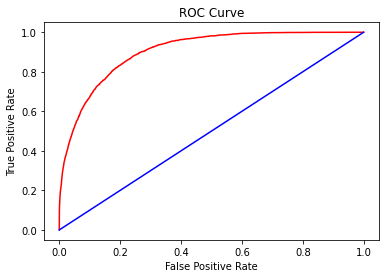

In [34]:
import pickle
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load dataset
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
#train prediction model    
c = 0.3
lr2 = LogisticRegression(solver = 'lbfgs', C= c, max_iter = 1000)
lr2.fit(adult50kp['x_train'], adult50kp['y_train'])
#make prediction
ypred = lr2.predict(adult50kp['x_test'])
ypredprob = lr2.predict_proba(adult50kp['x_test'])
#compute accuracy
ncorrect = np.sum(adult50kp['y_test'] == ypred)
accuracy_sk = ncorrect / adult50kp['y_test'].shape[0]
print("Accuracy = %f" % accuracy_sk) 

# decide thresholds by sorted ypredprob
thresholds = np.sort(ypredprob[:, 1])[::-1]
thresholds = np.append(thresholds[0]+1, thresholds)
index = []
for i in range(len(thresholds)):
    if i % 5 != 0:
        index.append(i)
thresholds = np.delete(thresholds, index)

# compute fpr & tpr
fpr, tpr = [], []
for i in range(len(thresholds)):
    tp, fn, fp, tn = 0, 0, 0, 0
    for j in range(len(adult50kp['y_test'])):
        if adult50kp['y_test'][j] == 1:
            if ypredprob[j, 1] >= thresholds[i]:
                tp += 1
            else:
                fn += 1
        else:
            if ypredprob[j, 1] >= thresholds[i]:
                fp += 1
            else:
                tn += 1
    fpr.append(fp/(fp+tn))
    tpr.append(tp/(tp+fn))
    
# plot the roc curve
plt.plot(fpr, tpr, color='r')
plt.plot([0, 1], [0, 1], color='b')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()   

#### Q2.2 計算繪製出的ROC Curve的AUC
按照助教所提供的方法，以計算梯形的方式來當作曲線面積的近似值，因此以每個threshold作為間隔，將計算出的梯形面積累加即可得到AUC的近似值

In [35]:
# compute auc base on roc curve
auc = 0
for i in range(len(thresholds)-1):
    auc += (tpr[i+1] + tpr[i]) * (fpr[i+1] - fpr[i]) / 2
print("AUC = ", auc)

AUC =  0.9034924462314518


### 第三題 [Logistic Regression with L2 Regularization]

#### Q1.1 Derive the gradient and hessian matrix for the new E(w)
$$E(w) = \frac{1}{2} w^T \Lambda w - \sum_{n=1}^N [ t_n \ln y_n  + (1 - t_n) \ln (1 - y_n)]\ ,\ where\ y_n = \frac{1}{1 + exp({-w^Tx_n})}$$
<br>
<br>
$$Let\ z_1 = \sum_{n=1}^N (t_n \ln y_n)\ ,\ z_2 = \sum_{n=1}^N [(1 - t_n) \ln (1 - y_n)]\ , \ where\ y_n = \sigma (w^Tx_n)$$
<br>
<br>
$$\frac{∂z_1}{∂w} = \frac{t_n \sigma(w^Tx_n)(1 - \sigma(w^Tx_n)x_n}{ \sigma(w^Tx_n)} = t_n(1 - \sigma(w^Tx_n)x_n$$
<br>
<br>
$$\frac{∂z_2}{∂w} = \frac{(1 - t_n) \sigma(w^Tx_n)(1 - \sigma(w^Tx_n)(- x_n)}{1 - \sigma(w^Tx_n)} = (t_n - 1) \sigma(w^Tx_n)x_n$$
<br>
<br>
$$\frac{∂z_1}{∂w} + \frac{∂z_2}{∂w} = (t_n - \sigma(w^Tx_n)x_n$$
<br>
<br>
$$\nabla E(w) = \frac{∂E(w)}{∂w} = \Lambda w - \sum_{n=1}^N (t_n - \sigma(w^Tx_n)x_n = \Lambda w + \Phi^T(y-t)$$
<br>
<br>
$$Hessian = \nabla \nabla E(w) = \sum_{n=1}^N y_n (1 - y_n) x_n x_n^T + \Lambda = \Phi^T R \Phi + \Lambda \ ,\ where\ R\ is\ a\ diagonal\ matrix\ with\ R_{nn} = y_n (1 - y_n)$$

#### Q1.2 Create your mylogistic_l2 class
以下為我實作的mylogistic_l2架構，其中主要分為三個函式:
* init() 是用來定義這個class的參數
* fit() 是主要用來做training的函式，先按照add_intercept決定是否加入全為1的column，利用ridge regression找出一個初始的weight，接著按照上一小題得出的gradient和hessian來實作newton raphson method，以此更新weight，比較更新weight前後的error來判斷是否收斂，收斂後存下error最低的weight
* predict() 是用來做prediction的，將計算後得出的機率以0.5為threshold判斷為label 1或0

In [11]:
class mylogistic_l2():
    def __init__(self, reg_vec, max_iter = 100, tol = 1e-5, add_intercept = True):
        # initialize the parameters
        self.reg_vec = reg_vec
        self.max_iter = max_iter
        self.tol = tol
        self.add_intercept = add_intercept

    def fit(self, x, y, verbal = False):
        # add intercept at the end of x
        if self.add_intercept:
            intercept = np.ones((x.shape[0], 1))
            x = np.concatenate((x, intercept), axis=1)
            
        # compute initial w by ridge regression
        b = np.sum(self.reg_vec)/len(self.reg_vec)
        w = np.dot(np.linalg.inv(b * np.identity(x.shape[1]) + np.dot(x.transpose(), x)), np.dot(x.transpose(), y))
        
        
        # compute the error function E(w)
        ypred = np.clip(1 / (1.0 + np.exp(-np.dot(x, w))), 1e-8, 1-(1e-8))
        E = np.dot(np.dot(w, self.reg_vec), w)/2 - (np.dot(y, np.log(ypred)) + np.dot((1-y), np.log(1-ypred)))

        self.w = w
        E_min = E

        for i in range(self.max_iter): 
            # implement logistic regression with newton raphson method
            ypred = np.clip(1 / (1.0 + np.exp(-np.dot(x, w))), 1e-8, 1-(1e-8))
            gradient =  np.dot(x.transpose(), (ypred - y)) + np.dot(w, self.reg_vec)
            R = np.identity(len(ypred))
            for j in range(len(ypred)):
                R[j][j] = ypred[j] * (1 - ypred[j])
            Hessian = np.dot(np.dot(x.transpose(), R), x) + self.reg_vec
            w = w - np.dot(np.linalg.inv(Hessian), gradient)
            
            # compute the error after an iteration
            ypred = np.clip(1 / (1.0 + np.exp(-np.dot(x, w))), 1e-8, 1-(1e-8))
            E_new = np.dot(np.dot(w, self.reg_vec), w)/2 - (np.dot(y, np.log(ypred)) + np.dot((1-y), np.log(1-ypred)))
            
            # update w with the lowest error
            if E_new < E_min:
                self.w = w
                E_min = E_new

            # compare the error before and after an iteration
            if np.abs(E - E_new) < self.tol:
                break
            
            E = E_new
            
        if verbal:
            print("w = \n", self.w)
            
            
    def predict(self, x):
        if self.add_intercept:
            intercept = np.ones((x.shape[0], 1))
            x = np.concatenate((x, intercept), axis=1)
        
        # predict with trained weight
        ypred = np.clip(1 / (1.0 + np.exp(-np.dot(x, self.w))), 1e-8, 1-(1e-8))
        ypred = np.array([1 if y >= 0.5 else 0 for y in ypred])
        return ypred


In [12]:
def accuracy(ypred, y_test):
    acc = 1 - np.mean(np.abs(ypred - y_test))
    return acc
        
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
np.set_printoptions(suppress=True)

# case 1: lambda = 1 for all coefficients
lambda_vec = np.identity(adult50kp['x_train'].shape[1]+1)

print("case 1 : ")
logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic1.fit(adult50kp['x_train'], adult50kp['y_train'], verbal=True)
ypred = logic1.predict(adult50kp['x_test'])
print("test accuracy = ", accuracy(ypred, adult50kp['y_test']))
print()

# case 2: lambda = 1 for all but the intercept, no regularization for intercept term
lambda_vec = np.identity(adult50kp['x_train'].shape[1]+1)
lambda_vec[-1][-1] = 0

print("case 2 : ")
logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic1.fit(adult50kp['x_train'], adult50kp['y_train'], verbal=True)
ypred = logic1.predict(adult50kp['x_test'])
print("test accuracy = ", accuracy(ypred, adult50kp['y_test']))
print()

# case 3: lambda = 1 for numerical-valued features, lambda = 0.5 for binary-valued features, no regularization for intercept term
lambda_vec = np.identity(adult50kp['x_train'].shape[1]+1)
for i in range(len(lambda_vec)):
    if i > 5:
        lambda_vec[i][i] = 0.5
    if i == len(lambda_vec)-1:
        lambda_vec[i][i] = 0

print("case 3 : ")
logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic1.fit(adult50kp['x_train'], adult50kp['y_train'], verbal=True)
ypred = logic1.predict(adult50kp['x_test'])
print("test accuracy = ", accuracy(ypred, adult50kp['y_test']))

case 1 : 
w = 
 [ 0.25831075  0.35295138  2.33390165  0.75114521  0.33352443  0.07923687
 -0.25930599 -0.03310592 -0.80209231 -1.16328376 -0.15748027  1.06974337
 -0.63384606  0.11673241 -0.23156738 -0.5171222  -0.07972164 -1.0994978
 -0.24602708  0.06196949  0.12668588  0.86265606 -0.91835285 -0.62122618
 -0.20074023 -0.75160098 -1.61011588  0.57582091  0.64899529  0.35374143
  0.71721848 -0.02844947 -0.00095482 -0.1965409  -0.14635164  0.62694628
  0.44820708  0.02459458  0.04692237 -0.49106775 -0.20303543 -0.16330368
 -0.01766235 -0.11132832 -0.09946183 -1.17391916  0.18070269 -0.069272
  0.97649691  0.46098861 -0.49544042 -1.27203531  0.48677241 -0.89896372
 -0.06005426 -0.35084886  0.43281522  0.59412014  0.58215192 -0.6209623
 -0.05974804  0.09290353 -0.1518921  -0.00538528  0.0341609  -0.28908824
  0.15605391  0.49540124  0.89094226  0.14915144  0.34248478 -0.31331216
 -0.35593911 -0.3624946  -0.66724747 -0.40883113  0.44748984  0.13776893
  0.14135123 -0.11601542 -0.05610327 -0

#### Q1.3 Further split the training data into subtraining (90%) and tuning (10%) to search for the best hyperparameters
以下為我實作的方式，先對資料做random shuffle並且按照比例分為subtraining和tuning，而我有固定random seed方便reproduce，接著我設了一組grid，範圍為[0.01, 100]，設定$a_1 = a_2$並找出一個最佳的grid，接著分別固定$a_1$和$a_2$來找出連續性和非連續性資料最佳的$ \lambda$，最後我找出的結果為$a_1 = 5, a_2 = 5$，並將這個結果做訓練後預測得到的test accuracy為$84.86$%

In [18]:
# random shuffle
np.random.seed(10)
randomize = np.arange(len(adult50kp['x_train']))
np.random.shuffle(randomize)
x_subtrain = adult50kp['x_train'][randomize][:int(len(adult50kp['x_train'])*0.9)]
x_tune = adult50kp['x_train'][randomize][int(len(adult50kp['x_train'])*0.9):]
y_subtrain = adult50kp['y_train'][randomize][:int(len(adult50kp['y_train'])*0.9)]
y_tune = adult50kp['y_train'][randomize][int(len(adult50kp['y_train'])*0.9):]


# set the grid
grid = [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100]

for i in range(len(grid)):
    lambda_vec = grid[i] * np.identity(x_subtrain.shape[1]+1)
    lambda_vec[-1][-1] = 0
    
    logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 100, tol = 1e-5, add_intercept = True)
    logic1.fit(x_subtrain, y_subtrain)
    ypred = logic1.predict(x_tune)
    print("grid = "+str(grid[i])+", test accuracy = "+str(accuracy(ypred, y_tune)))
  

grid = 0.01, test accuracy = 0.8478621146834604
grid = 0.025, test accuracy = 0.848193569771296
grid = 0.05, test accuracy = 0.848193569771296
grid = 0.075, test accuracy = 0.848193569771296
grid = 0.1, test accuracy = 0.848193569771296
grid = 0.25, test accuracy = 0.8475306595956248
grid = 0.5, test accuracy = 0.8478621146834604
grid = 0.75, test accuracy = 0.848193569771296
grid = 1, test accuracy = 0.848193569771296
grid = 2.5, test accuracy = 0.849850845210474
grid = 5, test accuracy = 0.8501823002983095
grid = 7.5, test accuracy = 0.8495193901226383
grid = 10, test accuracy = 0.8491879350348028
grid = 25, test accuracy = 0.8488564799469672
grid = 50, test accuracy = 0.848193569771296
grid = 75, test accuracy = 0.849850845210474
grid = 100, test accuracy = 0.848193569771296


In [50]:
# set a1* = 5
grid_best = 5
for i in range(len(grid)):
    lambda_vec = grid[i] * np.identity(x_subtrain.shape[1]+1)
    for j in range(6):
        lambda_vec[j][j] = grid_best
    lambda_vec[-1][-1] = 0
    
    logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 100, tol = 1e-5, add_intercept = True)
    logic1.fit(x_subtrain, y_subtrain)
    ypred = logic1.predict(x_tune)
    print("a1 = "+str(grid_best)+", a2 = "+str(grid[i])+", test accuracy = "+str(accuracy(ypred, y_tune)))

a1 = 5, a2 = 0.01, test accuracy = 0.8485250248591316
a1 = 5, a2 = 0.025, test accuracy = 0.8485250248591316
a1 = 5, a2 = 0.05, test accuracy = 0.8485250248591316
a1 = 5, a2 = 0.075, test accuracy = 0.8485250248591316
a1 = 5, a2 = 0.1, test accuracy = 0.8485250248591316
a1 = 5, a2 = 0.25, test accuracy = 0.8478621146834604
a1 = 5, a2 = 0.5, test accuracy = 0.8471992045077892
a1 = 5, a2 = 0.75, test accuracy = 0.8478621146834604
a1 = 5, a2 = 1, test accuracy = 0.8478621146834604
a1 = 5, a2 = 2.5, test accuracy = 0.8491879350348028
a1 = 5, a2 = 5, test accuracy = 0.8501823002983095
a1 = 5, a2 = 7.5, test accuracy = 0.8501823002983095
a1 = 5, a2 = 10, test accuracy = 0.8495193901226383
a1 = 5, a2 = 25, test accuracy = 0.8495193901226383
a1 = 5, a2 = 50, test accuracy = 0.8485250248591316
a1 = 5, a2 = 75, test accuracy = 0.8501823002983095
a1 = 5, a2 = 100, test accuracy = 0.848193569771296


In [55]:
# set a2* = 5
grid_best = 5
for i in range(len(grid)):
    lambda_vec = grid_best * np.identity(x_subtrain.shape[1]+1)
    for j in range(6):
        lambda_vec[j][j] = grid[i]
    lambda_vec[-1][-1] = 0
    
    logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 100, tol = 1e-5, add_intercept = True)
    logic1.fit(x_subtrain, y_subtrain)
    ypred = logic1.predict(x_tune)
    print("a1 = "+str(grid[i])+", a2 = "+str(grid_best)+", test accuracy = "+str(accuracy(ypred, y_tune)))

a1 = 0.01, a2 = 5, test accuracy = 0.849850845210474
a1 = 0.025, a2 = 5, test accuracy = 0.849850845210474
a1 = 0.05, a2 = 5, test accuracy = 0.849850845210474
a1 = 0.075, a2 = 5, test accuracy = 0.849850845210474
a1 = 0.1, a2 = 5, test accuracy = 0.849850845210474
a1 = 0.25, a2 = 5, test accuracy = 0.849850845210474
a1 = 0.5, a2 = 5, test accuracy = 0.849850845210474
a1 = 0.75, a2 = 5, test accuracy = 0.849850845210474
a1 = 1, a2 = 5, test accuracy = 0.8501823002983095
a1 = 2.5, a2 = 5, test accuracy = 0.8501823002983095
a1 = 5, a2 = 5, test accuracy = 0.8501823002983095
a1 = 7.5, a2 = 5, test accuracy = 0.8495193901226383
a1 = 10, a2 = 5, test accuracy = 0.8488564799469672
a1 = 25, a2 = 5, test accuracy = 0.8488564799469672
a1 = 50, a2 = 5, test accuracy = 0.8491879350348028
a1 = 75, a2 = 5, test accuracy = 0.8491879350348028
a1 = 100, a2 = 5, test accuracy = 0.848193569771296


In [84]:
# a1* = 5, a2* = 5
a1 = 5
a2 = 5
lambda_vec = a2 * np.identity(x_subtrain.shape[1]+1)
for i in range(6):
    lambda_vec[i][i] = a1
lambda_vec[-1][-1] = 0
logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic1.fit(adult50kp['x_train'], adult50kp['y_train'])
ypred = logic1.predict(adult50kp['x_test'])
print("test accuracy = ", accuracy(ypred, adult50kp['y_test']))

test accuracy =  0.848605577689243


#### Q1.4 Use sklearn.linear_model.LogisticRegression to train and test the model (including hyperparameter tuning). Compare the estimated parameters and test accuracy with those from your own models
以下為我的實作方式，先利用上一小題的grid set來對sklearn的logistic regression model做hyperparameter tuning，而我找出最佳的grid為0.25，而放進LogisticRegression的參數C，為regularization中$ \lambda$的倒數，也就是$ \frac{1}{ \lambda}$，因此找到最佳的$ \lambda$為4，跟我自己實作的model做hyperparameter tuning得出的結果相似，而sklearn的logistic regression model最後得到的test accuracy為$84.87$%，比我實作的model略好一些，而兩者使用的optimizer也都為newton method，也不對截距項做regularization，其中會有差別的地方我認為是初始化weight的方法不同，以我實作的model為例，利用ridge regression得到的weight做prediction的test accuracy只有約$44$%，但是sklearn的logistic regression model卻能夠有約$75$%的test accuarcy，雖然兩者model最後都訓練至收斂，但這初始化方法的不同可能就是最後結果有些許差異的主要原因

In [9]:
# hyperparameter tuning of sklearn model
from sklearn.linear_model import LogisticRegression
for i in range(len(grid)):
    lr2 = LogisticRegression(solver = 'newton-cg', C = grid[i], max_iter = 1000, fit_intercept = False)
    lr2.fit(x_subtrain, y_subtrain)
    ypred = lr2.predict(x_tune)
    print("grid = "+str(grid[i])+", test accuracy = "+str(accuracy(ypred, y_tune)))

grid = 0.01, test accuracy = 0.8468677494199536
grid = 0.025, test accuracy = 0.8485250248591316
grid = 0.05, test accuracy = 0.8491879350348028
grid = 0.075, test accuracy = 0.8491879350348028
grid = 0.1, test accuracy = 0.8488564799469672
grid = 0.25, test accuracy = 0.8508452104739808
grid = 0.5, test accuracy = 0.8495193901226383
grid = 0.75, test accuracy = 0.848193569771296
grid = 1, test accuracy = 0.848193569771296
grid = 2.5, test accuracy = 0.8478621146834604
grid = 5, test accuracy = 0.8478621146834604
grid = 7.5, test accuracy = 0.848193569771296
grid = 10, test accuracy = 0.848193569771296
grid = 25, test accuracy = 0.848193569771296
grid = 50, test accuracy = 0.8478621146834604
grid = 75, test accuracy = 0.8478621146834604
grid = 100, test accuracy = 0.8478621146834604


In [10]:
lr2 = LogisticRegression(solver = 'newton-cg', C = 0.25, max_iter = 1000, fit_intercept = False)
lr2.fit(adult50kp['x_train'], adult50kp['y_train'])
ypred = lr2.predict(adult50kp['x_test'])
print(lr2.get_params())
print("test accuracy = ", accuracy(ypred, adult50kp['y_test']))

{'C': 0.25, 'class_weight': None, 'dual': False, 'fit_intercept': False, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
test accuracy =  0.8487383798140771
